In [1]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        
from imap.data.image_rendering_data_module import ImageRenderingDataModule
from imap.model.nerf import NERF
from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import os
from pathlib import Path
import torch
from tqdm.notebook import tqdm

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load images

In [3]:
color_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/rgb/1305031464.959763.png"))
depth_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/depth/1305031464.952471.png"))

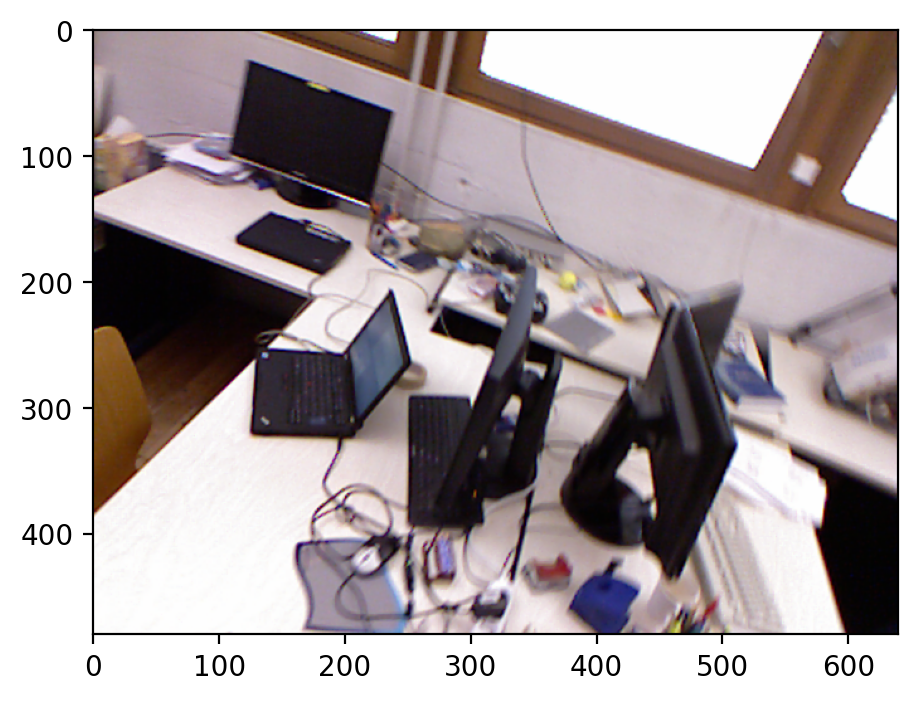

In [4]:
figure = plt.figure(dpi=200)
color_image = cv2.imread(color_image_path)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))

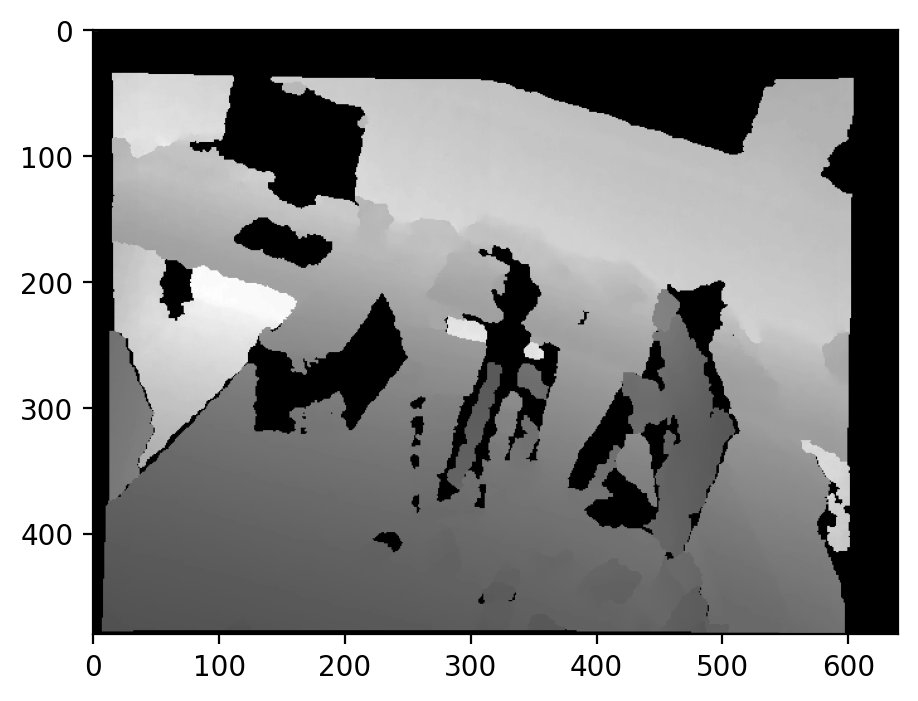

In [5]:
figure = plt.figure(dpi=200)
depth_image = cv2.imread(depth_image_path, -1).astype(np.float32) / 5000
depth_image = np.clip(depth_image, 0, 4)
plt.imshow(depth_image, cmap="gray")

In [6]:
dataset_params = {'dataset_path': "/media/mikhail/Data3T/tum_rgbd", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [131, 257, 325, 407, 455]}
# dataset_params=1
data_module = ImageRenderingDataModule('tum', **dataset_params)

Reading /media/mikhail/Data3T/tum_rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt
Read (5, 480, 640, 3) images array
Dataset size: 1536000 pixels
[ToyDataModule] - train subset size 1536000


In [7]:
parameters = AttributeDict(
    name="NERF",
    optimizer=AttributeDict(),
    encoding_dimension=93,
    course_sample_bins=32,
    fine_sample_bins=12,
    maximal_distance=4,
    depth_loss_koef=0.5,
    encoding_sigma=5,
    optimize_positions=False,
)
factory = UniversalFactory([NERF])
model = factory.make_from_parameters(parameters, camera_info=data_module.camera_info())

In [8]:
# logger_path = os.path.join(os.path.dirname(task.cache_dir), "lightning_logs", "sparse_feature_pyramid")
logger_path = os.path.join("lightning_logs", "sparse_feature_pyramid")
trainer_parameters = {
    "max_epochs": 1,
    "checkpoint_every_n_val_epochs": 10,
    "gpus": 1,
    "check_val_every_n_epoch": 2
}
# task.connect(trainer_parameters)
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss',
    every_n_val_epochs=trainer_parameters["checkpoint_every_n_val_epochs"])
trainer = factory.kwargs_function(pl.Trainer)(
    logger=TensorBoardLogger(logger_path, name="chess"),
    callbacks=[],
    **trainer_parameters
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [9]:
# trainer.fit(model, data_module);

# Show the results

In [10]:
from scipy.spatial.transform import Rotation

In [11]:
def get_position(translation, rotation):
    matrix_position = np.eye(4)
    matrix_position[:3, 3] = translation
    matrix_position[:3, :3] = Rotation.from_euler("xyz", rotation).as_matrix()
    return matrix_position

In [12]:
y, x = np.meshgrid(range(color_image.shape[0]), range(color_image.shape[1]))                                  
pixels = np.array([x, y], dtype=np.float32).T
pixels = torch.tensor(pixels).cuda().reshape(-1, 2)
# position = get_position(np.array([0, 0, 0]), np.array([0, 0, 0]))
position = data_module._dataset._positions[0]
# delta_position = get_position(np.array([0, 0, -1]), np.array([0.3, 0, 0]))
# delta_position = get_position(np.array([0, 0, 0.3]), np.array([0, 0, 0]))
# position = delta_position @ position
positions = torch.repeat_interleave(torch.tensor(position.astype(np.float32))[None], pixels.shape[0],
                                  dim=0).cuda()

In [13]:
batch_size = 4096
batch_count = pixels.shape[0] // batch_size
output_course_color = []
output_course_depth = []
output_fine_color = []
output_fine_depth = []
model = model.cuda()
model.eval()
with torch.no_grad():
    for i in tqdm(range(batch_count)):
        output = model(pixels[i * batch_size:i * batch_size + batch_size],
                             positions[i * batch_size:i * batch_size + batch_size])
        output_course_color.append(output[0])
        output_course_depth.append(output[1])
        output_fine_color.append(output[2])
        output_fine_depth.append(output[3])

  0%|          | 0/75 [00:00<?, ?it/s]

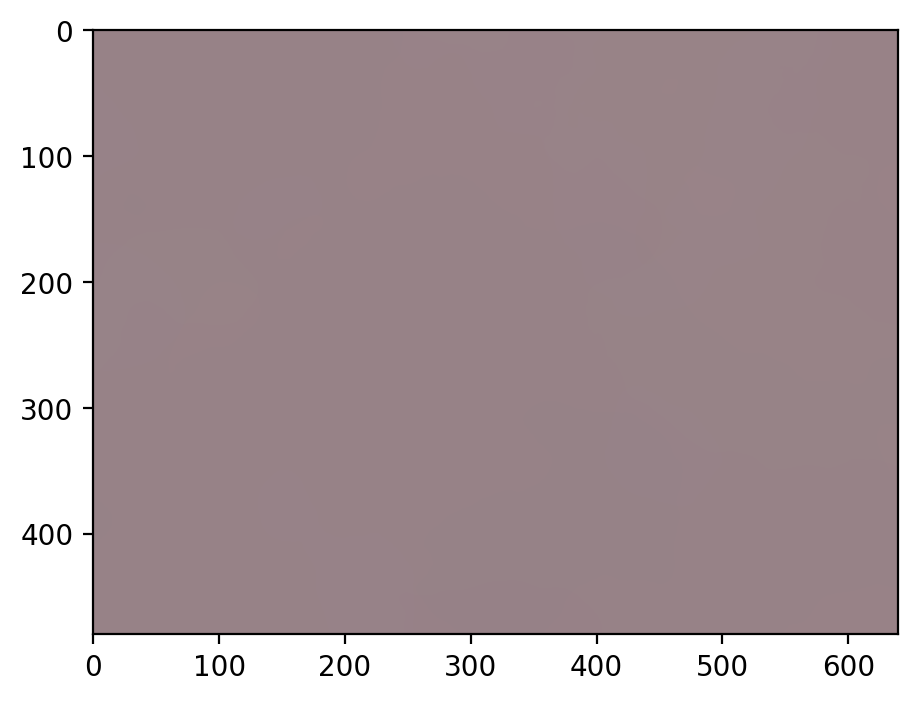

In [14]:
reconstructed_image = torch.cat(output_course_color, dim=0).reshape(480, 640, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

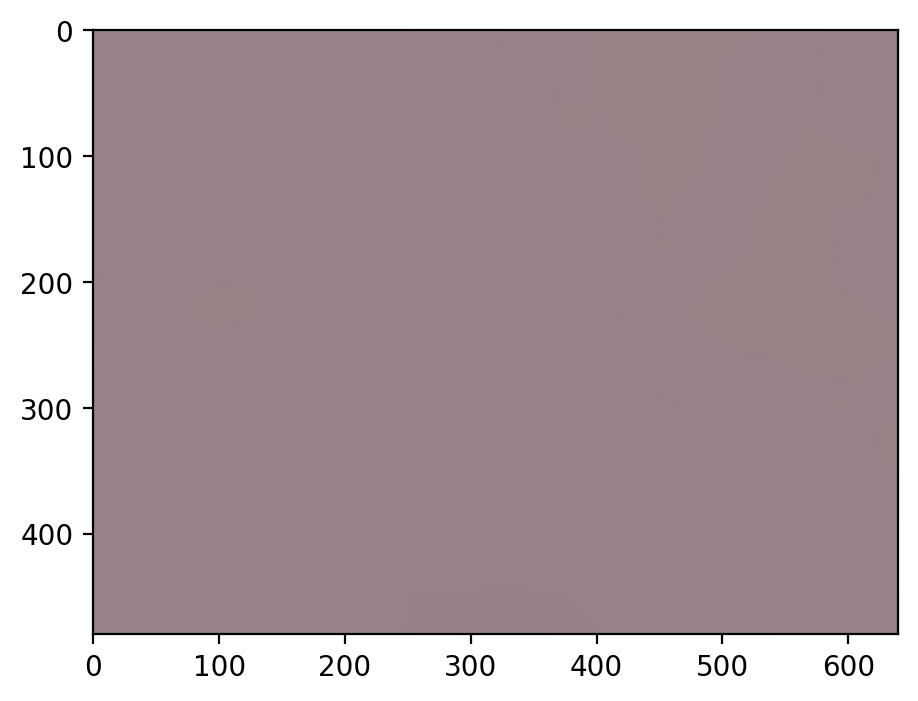

In [15]:
reconstructed_image = torch.cat(output_fine_color, dim=0).reshape(480, 640, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

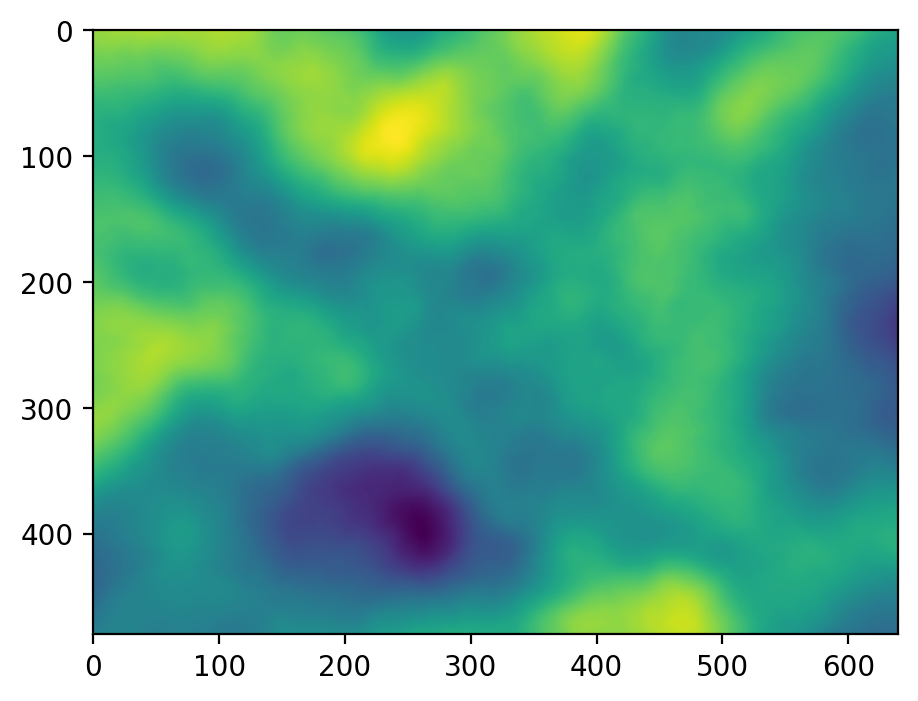

In [16]:
reconstructed_depth = torch.cat(output_course_depth, dim=0).reshape(480, 640).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

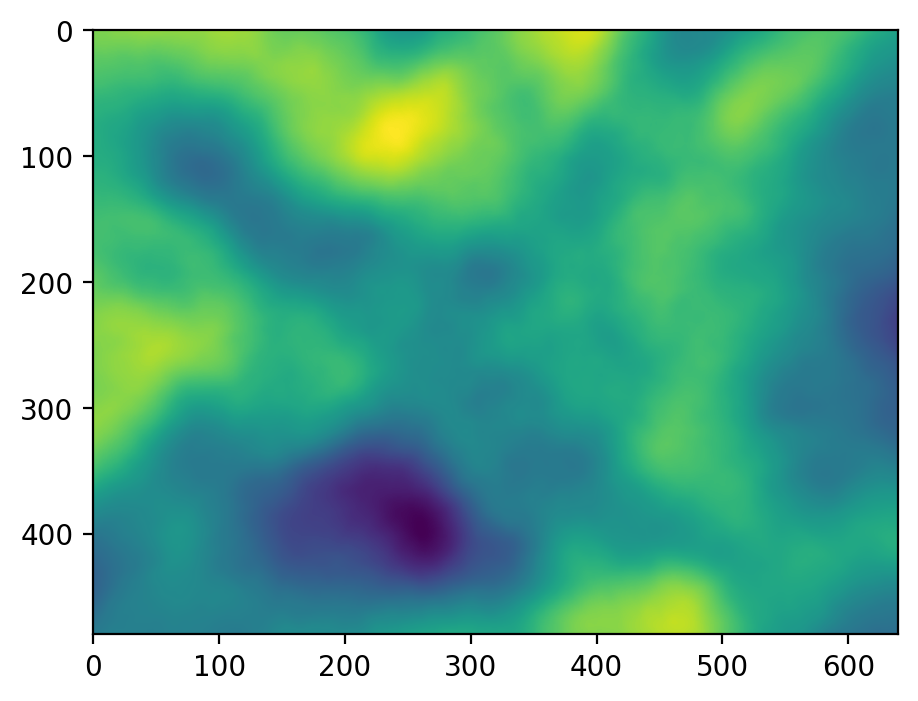

In [17]:
reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480, 640).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

# Test map builder

In [18]:
from imap.slam.imap_data_loader import IMAPDataLoader
from imap.slam.active_sampler import ActiveSampler
from imap.slam.keyframe_validator import KeyframeValidator
from imap.slam.imap_map_builder import IMAPMapBuilder
from imap.data.tum_frame_loader import TUMFrameLoader
from imap.slam.posed_frame import PosedFrame

In [19]:
dataset_path = "/media/mikhail/Data3T/tum_rgbd"
scene_name = "rgbd_dataset_freiburg1_desk"
association_file_name = "data_association_file.txt"
camera_info = data_module._dataset._camera_info
trainer = pl.Trainer(max_epochs=1, gpus=1)
map_builder_data_loader = IMAPDataLoader(100, 200, camera_info)

sampler_data_loader = IMAPDataLoader(1, 200, camera_info)
sampler = ActiveSampler(sampler_data_loader, 4, 1)

keyframe_validator_data_loader = IMAPDataLoader(1, 200, camera_info)
keyframe_validator = KeyframeValidator(0.1, 0.9, keyframe_validator_data_loader)
builder = IMAPMapBuilder(trainer, model, map_builder_data_loader, sampler, keyframe_validator)
frames = TUMFrameLoader(dataset_path, scene_name, association_file_name, [1, 5, 10, 15, 20, 25])
frames = [PosedFrame(x, frames[0].ground_truth_position[:3, :]) for x in frames]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Reading /media/mikhail/Data3T/tum_rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [20]:
model.unfreeze_positions()

In [21]:
previous_frame = frames[0]
for frame in frames:
    frame.position = previous_frame.position
    builder.set_current_frame(frame)
    builder.step()
    previous_frame = frame


/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                       | Params
--------------------------------------------------------------------
0 | _mlp                 | MLP                        | 246 K 
1 | _positional_encoding | GaussianPositionalEncoding | 279   
2 | _loss                | L1Loss                     | 0     
--------------------------------------------------------------------
246 K     Trainable params
0         Non-trainable params
246 K     Total params
0.986     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                       | Params
--------------------------------------------------------------------
0 | _mlp                 | MLP                        | 246 K 
1 | _positional_encoding | GaussianPositionalEncoding | 279   
2 | _loss                | L1Loss                     | 0     
--------------------------------------------------------------------
246 K     Trainable params
0         Non-trainable params
246 K     Total params
0.986     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                       | Params
--------------------------------------------------------------------
0 | _mlp                 | MLP                        | 246 K 
1 | _positional_encoding | GaussianPositionalEncoding | 279   
2 | _loss                | L1Loss                     | 0     
--------------------------------------------------------------------
246 K     Trainable params
0         Non-trainable params
246 K     Total params
0.986     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                       | Params
--------------------------------------------------------------------
0 | _mlp                 | MLP                        | 246 K 
1 | _positional_encoding | GaussianPositionalEncoding | 279   
2 | _loss                | L1Loss                     | 0     
--------------------------------------------------------------------
246 K     Trainable params
0         Non-trainable params
246 K     Total params
0.986     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                       | Params
--------------------------------------------------------------------
0 | _mlp                 | MLP                        | 246 K 
1 | _positional_encoding | GaussianPositionalEncoding | 279   
2 | _loss                | L1Loss                     | 0     
--------------------------------------------------------------------
246 K     Trainable params
0         Non-trainable params
246 K     Total params
0.986     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                       | Params
--------------------------------------------------------------------
0 | _mlp                 | MLP                        | 246 K 
1 | _positional_encoding | GaussianPositionalEncoding | 279   
2 | _loss                | L1Loss                     | 0     
--------------------------------------------------------------------
246 K     Trainable params
0         Non-trainable params
246 K     Total params
0.986     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

In [22]:
[x.position[:3, :3] @ frames[0].position[:3, :3].T for x in frames]

[array([[ 1.0000001e+00,  1.0693988e-08,  1.5165027e-08],
        [ 1.0693988e-08,  1.0000000e+00, -1.9974351e-09],
        [ 1.5165027e-08, -1.9974351e-09,  9.9999988e-01]], dtype=float32),
 array([[ 0.9956379 ,  0.08799066,  0.03102655],
        [-0.08736852,  0.9959574 , -0.02087051],
        [-0.03273751,  0.01806878,  0.99930066]], dtype=float32),
 array([[ 0.99214244,  0.09756964,  0.07831732],
        [-0.09270258,  0.99366367, -0.06355236],
        [-0.08402187,  0.0557928 ,  0.99490076]], dtype=float32),
 array([[ 0.992613  , -0.01223935,  0.1207043 ],
        [ 0.02072955,  0.9973778 , -0.06933615],
        [-0.1195392 ,  0.07132614,  0.990264  ]], dtype=float32),
 array([[ 0.9776699 , -0.12899412,  0.16589856],
        [ 0.13383934,  0.9908338 , -0.01831819],
        [-0.16201495,  0.04011288,  0.98597264]], dtype=float32),
 array([[ 0.9623655 , -0.18878794,  0.19547828],
        [ 0.19354904,  0.9810758 , -0.0053694 ],
        [-0.19076535,  0.04300196,  0.9806932 ]], dtype

In [23]:
[x.frame.ground_truth_position[:3, :3] @ frames[0].frame.ground_truth_position[:3, :3].T for x in frames]

[array([[ 1.00000000e+00,  9.79193615e-10, -1.17093215e-08],
        [ 9.79193615e-10,  1.00000000e+00,  2.44982843e-08],
        [-1.17093215e-08,  2.44982843e-08,  1.00000000e+00]], dtype=float32),
 array([[ 0.99635285,  0.07667348,  0.03744623],
        [-0.07581277,  0.9968359 , -0.02388956],
        [-0.03915947,  0.02096352,  0.999013  ]], dtype=float32),
 array([[ 0.9930753 ,  0.08204641,  0.08408232],
        [-0.07539112,  0.9939809 , -0.07948744],
        [-0.0900979 ,  0.07259797,  0.9932834 ]], dtype=float32),
 array([[ 0.992998  , -0.03169088,  0.11380091],
        [ 0.04348893,  0.99375767, -0.10273504],
        [-0.10983477,  0.10696477,  0.98817754]], dtype=float32),
 array([[ 0.9704854 , -0.19317503,  0.1443658 ],
        [ 0.20321505,  0.9774005 , -0.05824015],
        [-0.12985268,  0.08585854,  0.987809  ]], dtype=float32),
 array([[ 0.91821855, -0.36821297,  0.14592406],
        [ 0.37908253,  0.92376196, -0.05440857],
        [-0.11476517,  0.10527627,  0.98779845

In [24]:
[x.frame.ground_truth_position for x in frames]

[array([[ 0.882051  ,  0.33039793, -0.33589175,  1.319     ],
        [ 0.47078338, -0.5897835 ,  0.6561391 ,  0.8446    ],
        [ 0.01868358, -0.73688036, -0.6757649 ,  1.5203    ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32),
 array([[ 0.9156302 ,  0.25637877, -0.30966312,  1.3531    ],
        [ 0.40197667, -0.59536195,  0.69567156,  0.8097    ],
        [-0.00600622, -0.76145524, -0.64818966,  1.5335    ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32),
 array([[ 0.9161401 ,  0.21776177, -0.33655185,  1.383     ],
        [ 0.39996573, -0.5525698 ,  0.73122776,  0.739     ],
        [-0.02673492, -0.80451626, -0.5933286 ,  1.5562    ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32),
 array([[ 0.8630815 ,  0.26291758, -0.43123615,  1.3814    ],
        [ 0.50428456, -0.49602973,  0.70686036,  0.6549    ],
        [-0.02805993, -0.82754385, -0.5606994 ,  1.5717    ]